# Load and Visualize MgSiO3 melt Data
* Focus on classical simulations of Spera et al. (2011)
    * we only analyze simulations produced with high-pressure potential set of Oganov et al. (2000)
* Also load First Principles MD data from deKoker et al. (2009)

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
CONSTS = models.CONSTS
import copy

In [3]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)
    
datasets = analysis['datasets']
param_tex_str = analysis['param_tex_str']

In [4]:
data = datasets['deKoker2009']
data_S11 = datasets['Spera2011']
# View data tables
tbl = data['table']
tbl.head()

,V,T,P,E,trust,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,True,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,True,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,True,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,True,0,2000.0,10.34
4,15.502791,3000,-0.570033,-6.844948,True,0,3000.0,15.50


## Visualize FPMD data of deKoker et al. (2009)

In [5]:
datamodel_S11 = analysis['datamodel']
eos_mod = copy.deepcopy(datamodel_S11['eos_mod'])

datamodel = datamod.init_datamodel(data, eos_mod)

# Set colorbar temperature properties
#cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
cmap = plt.get_cmap('coolwarm')

delT = np.diff(data['T_labels'])[0]


dE0 = 13.75
E0 = eos_mod.get_params()['E0'] + dE0
eos_mod.set_param_values(E0,param_names='E0')

V0 = eos_mod.get_params()['V0']
Tlbl = data['T_labels']
# cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.35,1.2,1001)

<IPython.core.display.Javascript object>


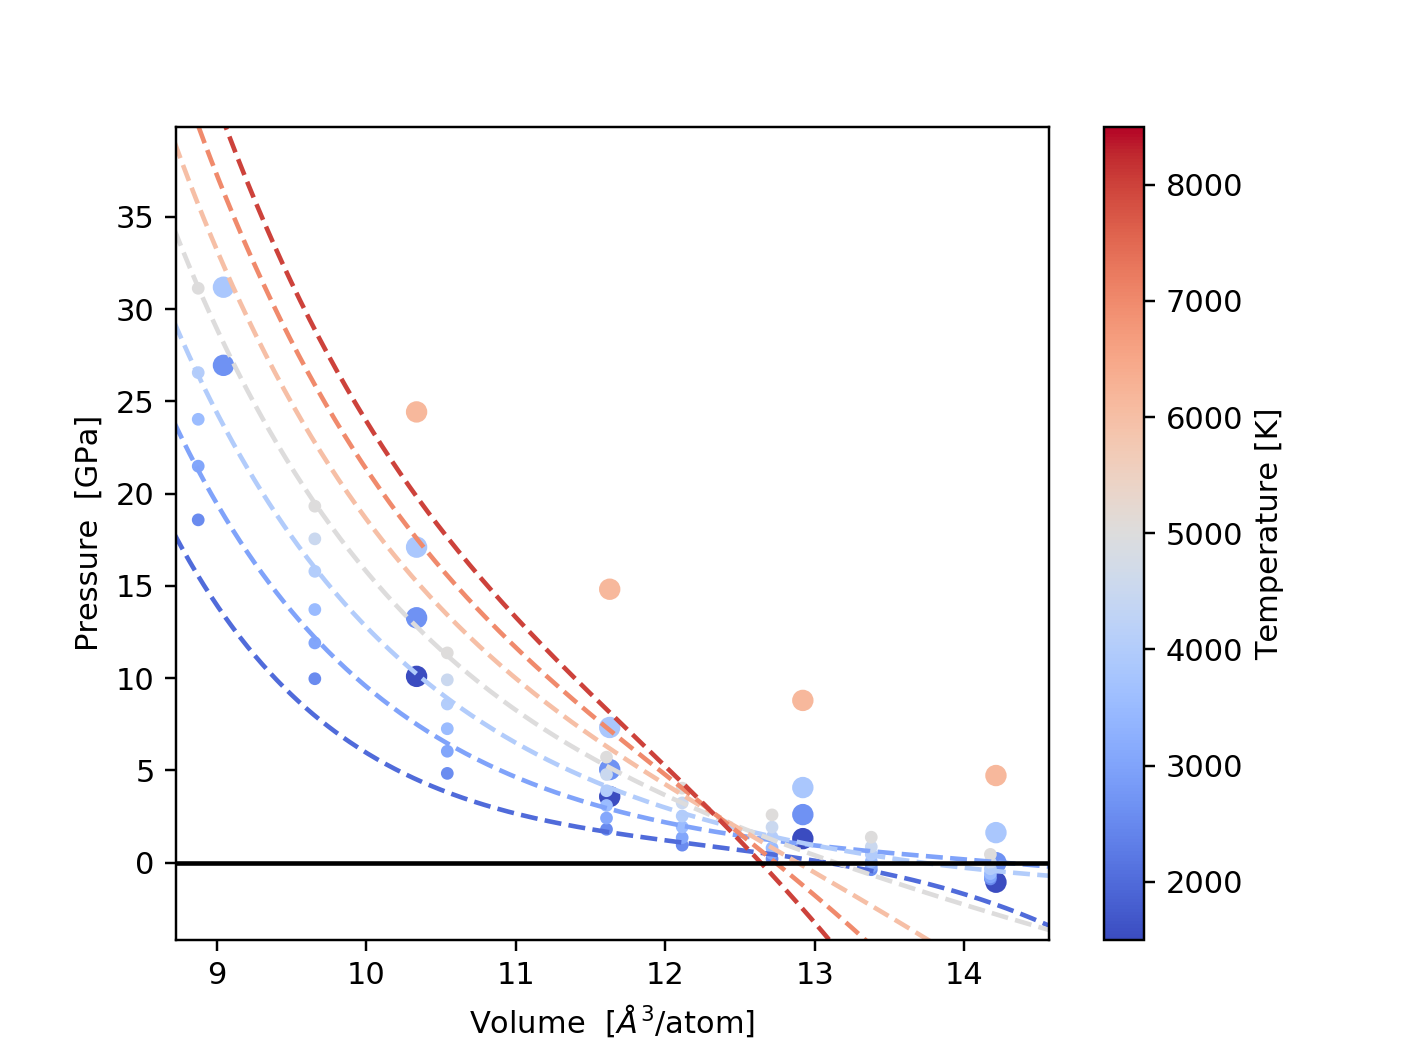

In [6]:

tbl_S11 = data_S11['table']

plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['V'],tbl_S11['P'],c=tbl_S11['T'], s=10, cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

# plt.ylim(-2,15);
plt.plot(Vmod,0*Vmod,'k-')


<IPython.core.display.Javascript object>


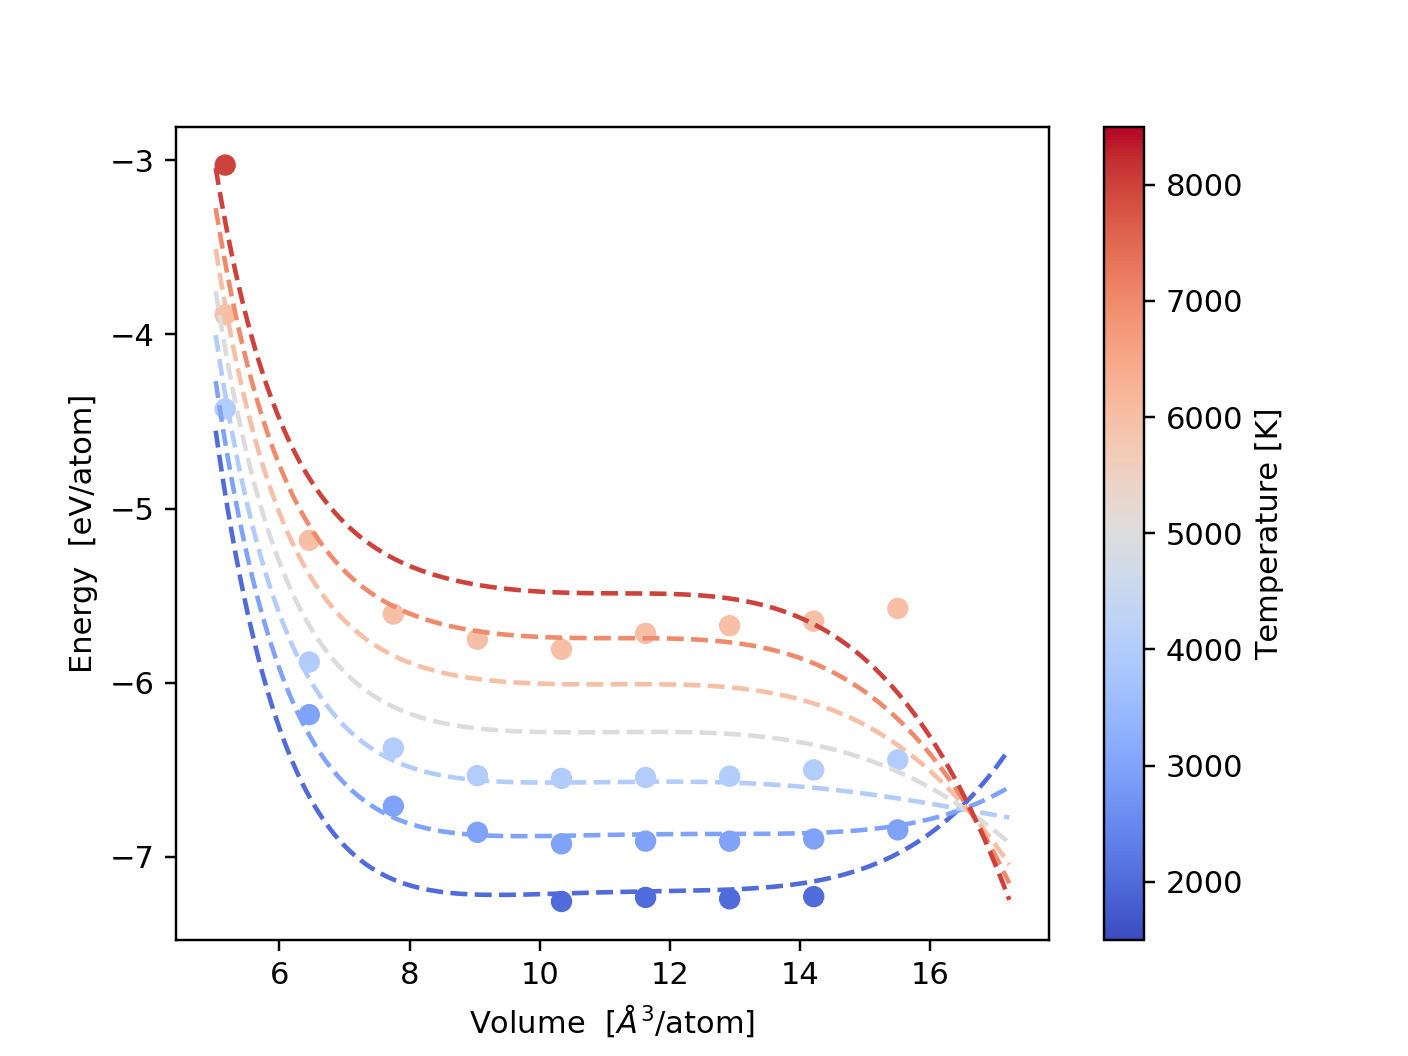

In [7]:


plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

<IPython.core.display.Javascript object>


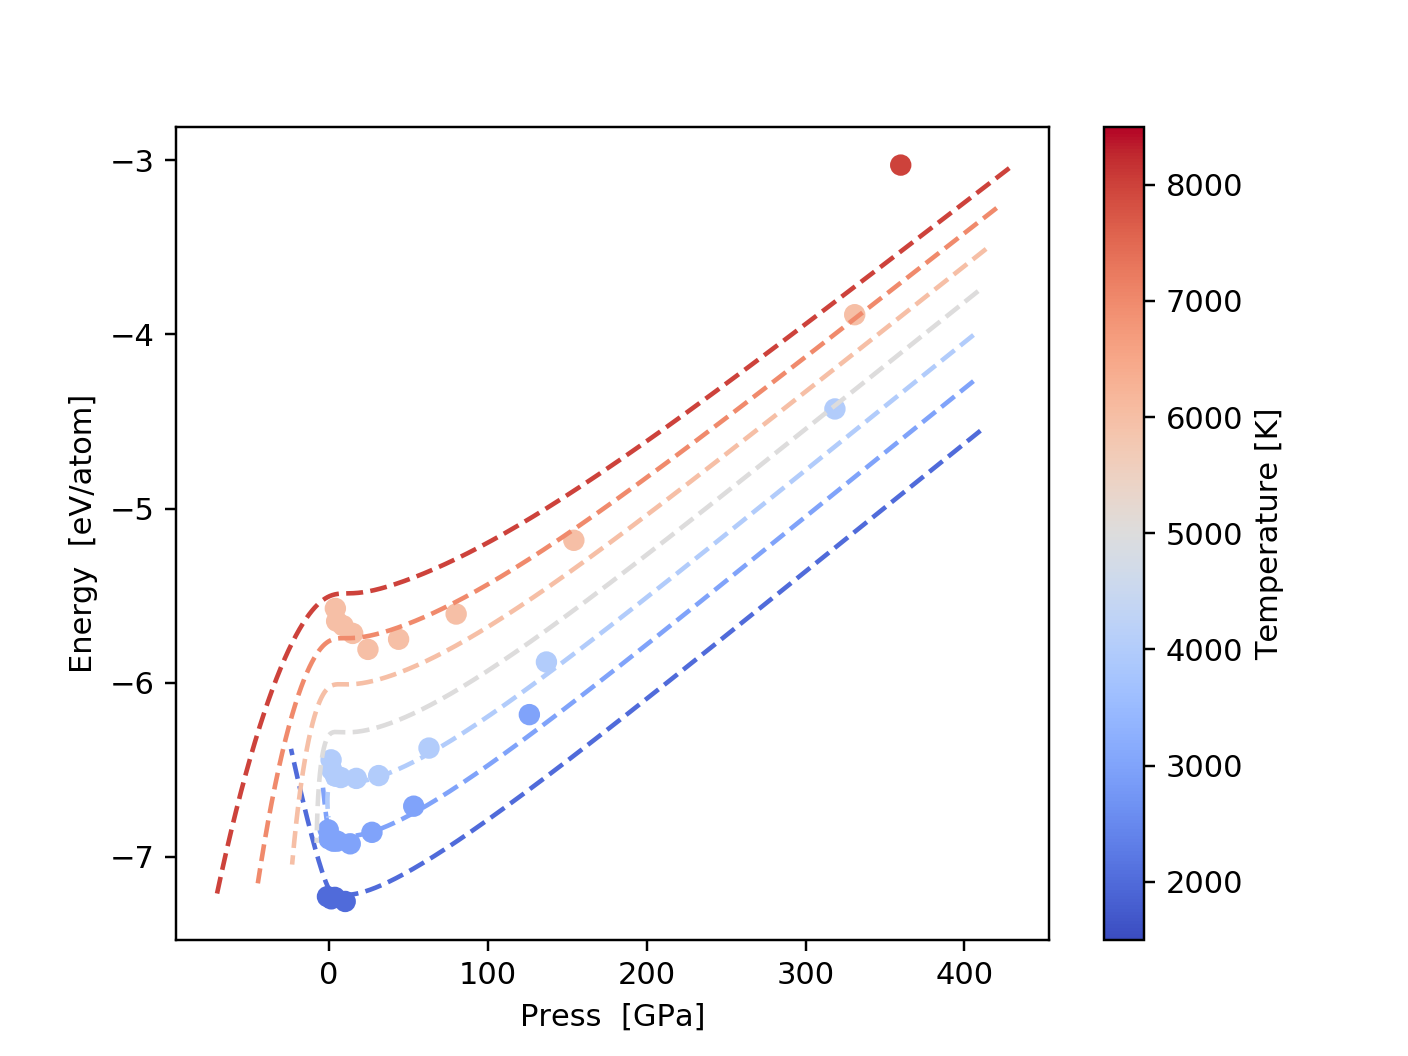

In [8]:


plt.figure()
plt.scatter(tbl['P'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(eos_mod.press(Vmod,iT),eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Press  [GPa]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [9]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0',
 'K0',
 'KP0',
 'E0',
 'gamma0',
 'gammap0',
 '_bcoef_0',
 '_bcoef_1',
 '_bcoef_2',
 '_bcoef_3',
 '_bcoef_4']

In [10]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [11]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99610371083398197, 'P': 0.99933726588831195, 'V': 0.99275324993002534}

'Model Residual Error = '

{'E': 0.067306365106268168, 'P': 3.1556259204843036, 'V': 0.30738492764602376}

,name,value,error
0,V0,15.665760,0.214271
1,K0,7.458285,0.991906
2,KP0,7.555068,0.215303
3,E0,-6.589169,0.016172
4,gamma0,0.258476,0.024898
5,gammap0,-1.224307,0.145993
6,_bcoef_0,1.705920,0.068376
7,_bcoef_1,0.393369,0.525290
8,_bcoef_2,-2.048414,3.945684
9,_bcoef_3,0.063496,11.883268


<IPython.core.display.Javascript object>


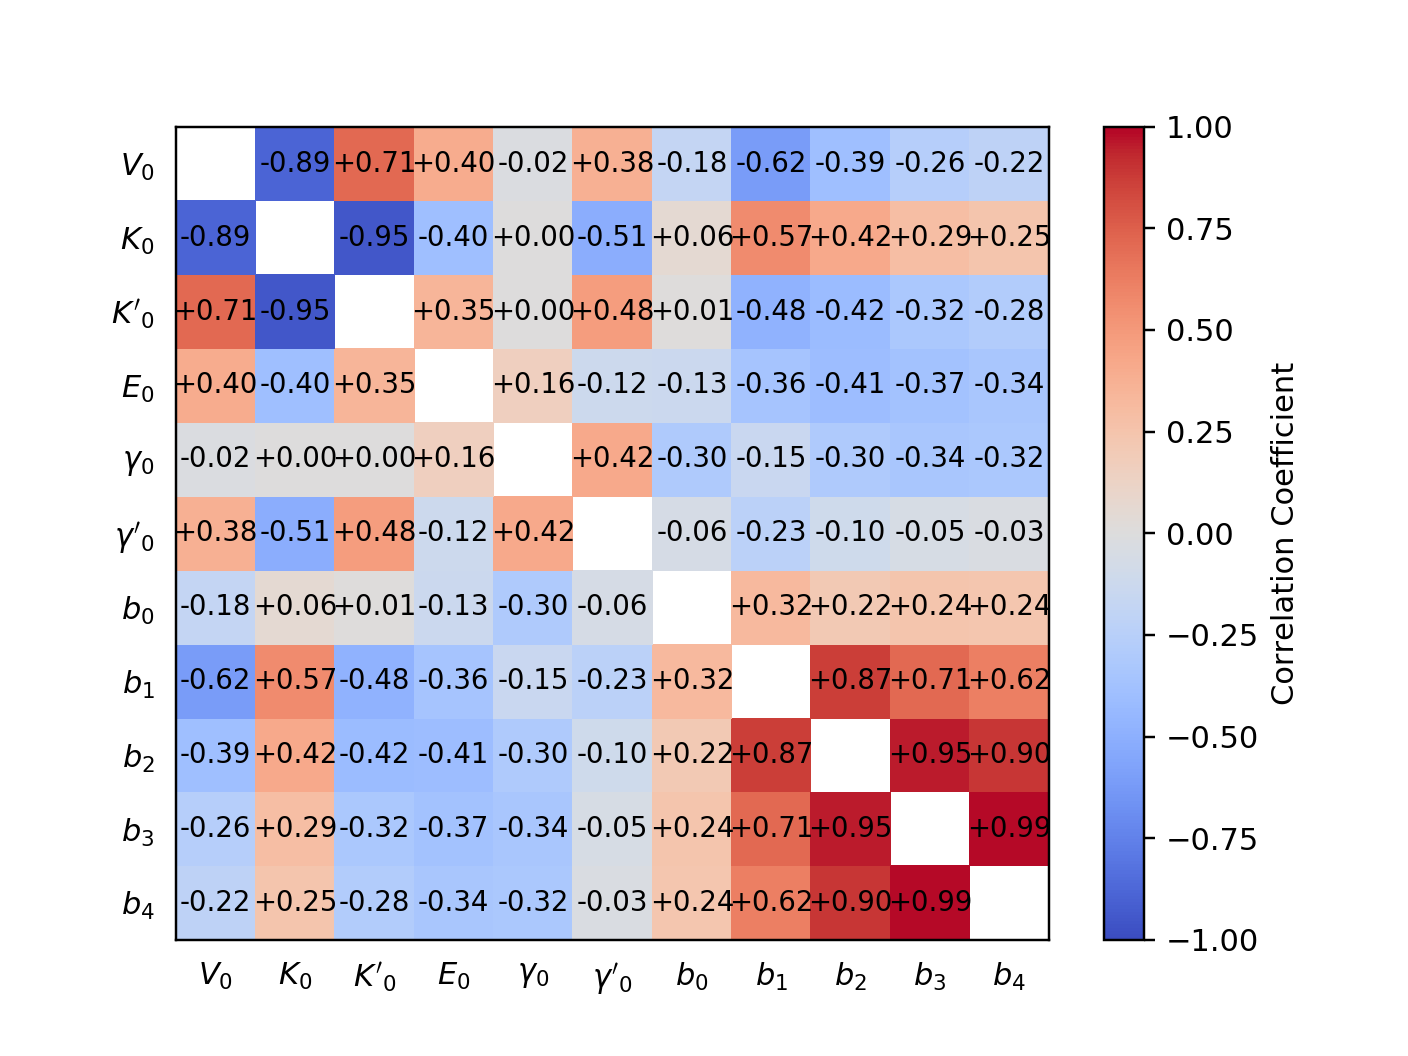

In [12]:
plt.figure()

posterior = datamodel['posterior']
corr = posterior['corr']

param_labels = [param_tex_str[name] for name in posterior['param_names']]


cmap = plt.get_cmap('coolwarm')
Nparam = len(param_labels)

corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
plt.pcolormesh(corr_plt,cmap=cmap)


# plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar(label=r'Correlation Coefficient')

plt.xticks(.5+np.arange(len(param_labels)),param_labels)
plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

for (index,val) in np.ndenumerate(np.flipud(corr)):
    if index[1]!=Nparam-1-index[0]:
        plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                 horizontalalignment='center', verticalalignment='center')

plt.setp(plt.gca().get_xticklines(),visible=False);
plt.setp(plt.gca().get_yticklines(),visible=False);

#plt.plot((0,11),(5,5),'k-',linewidth=2)
#plt.plot((0,11),(7,7),'k-',linewidth=2)
#plt.plot((4,4),(0,11),'k-',linewidth=2)
#plt.plot((6,6),(0,11),'k-',linewidth=2)
#plt.show()

In [13]:
from collections import OrderedDict
eos_mod = datamodel['eos_mod']
Tref = 1773
Vref = eos_mod.volume(0,Tref)
refvals = OrderedDict()
refvals['Vref'] = Vref
refvals['Kref'] = eos_mod.bulk_mod(Vref,Tref)
refvals['Cvref'] = eos_mod.heat_capacity(Vref,Tref)/models.CONSTS['kboltz']
display(refvals)

OrderedDict([('Vref', array([ 12.89519013])),
             ('Kref', array([ 17.21691043])),
             ('Cvref', array([ 5.62025015]))])

In [14]:
# datamod.fit(datamodel, apply_bulk_mod_wt=True)

<IPython.core.display.Javascript object>


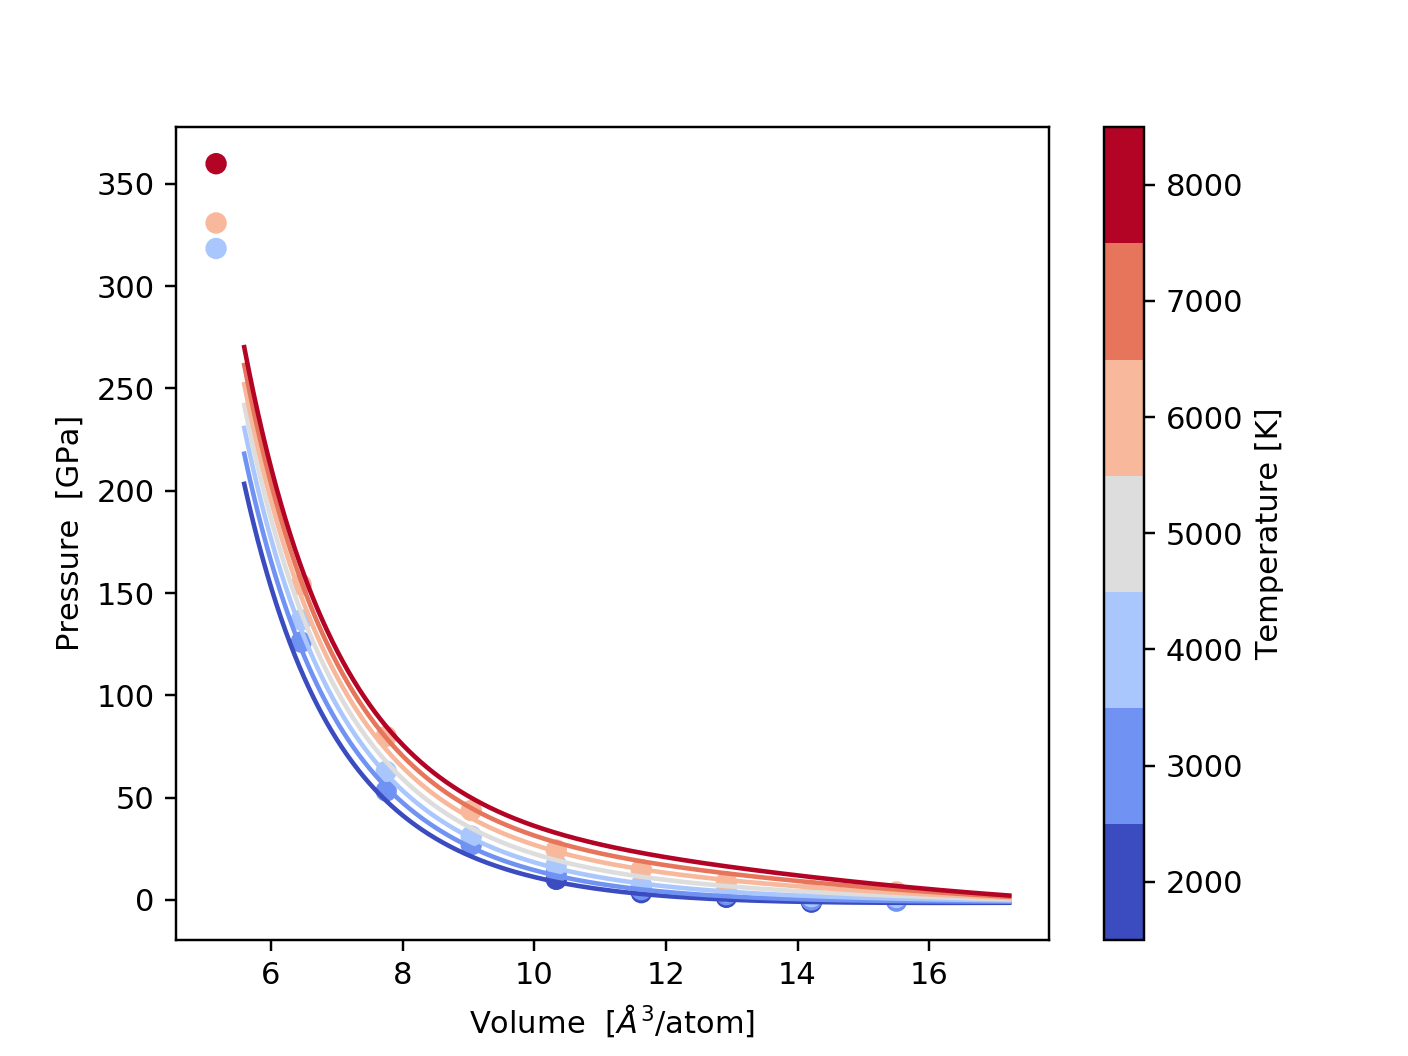

In [15]:
# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]
Vmod = V0*np.linspace(.39,1.2,1001)


plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


<IPython.core.display.Javascript object>


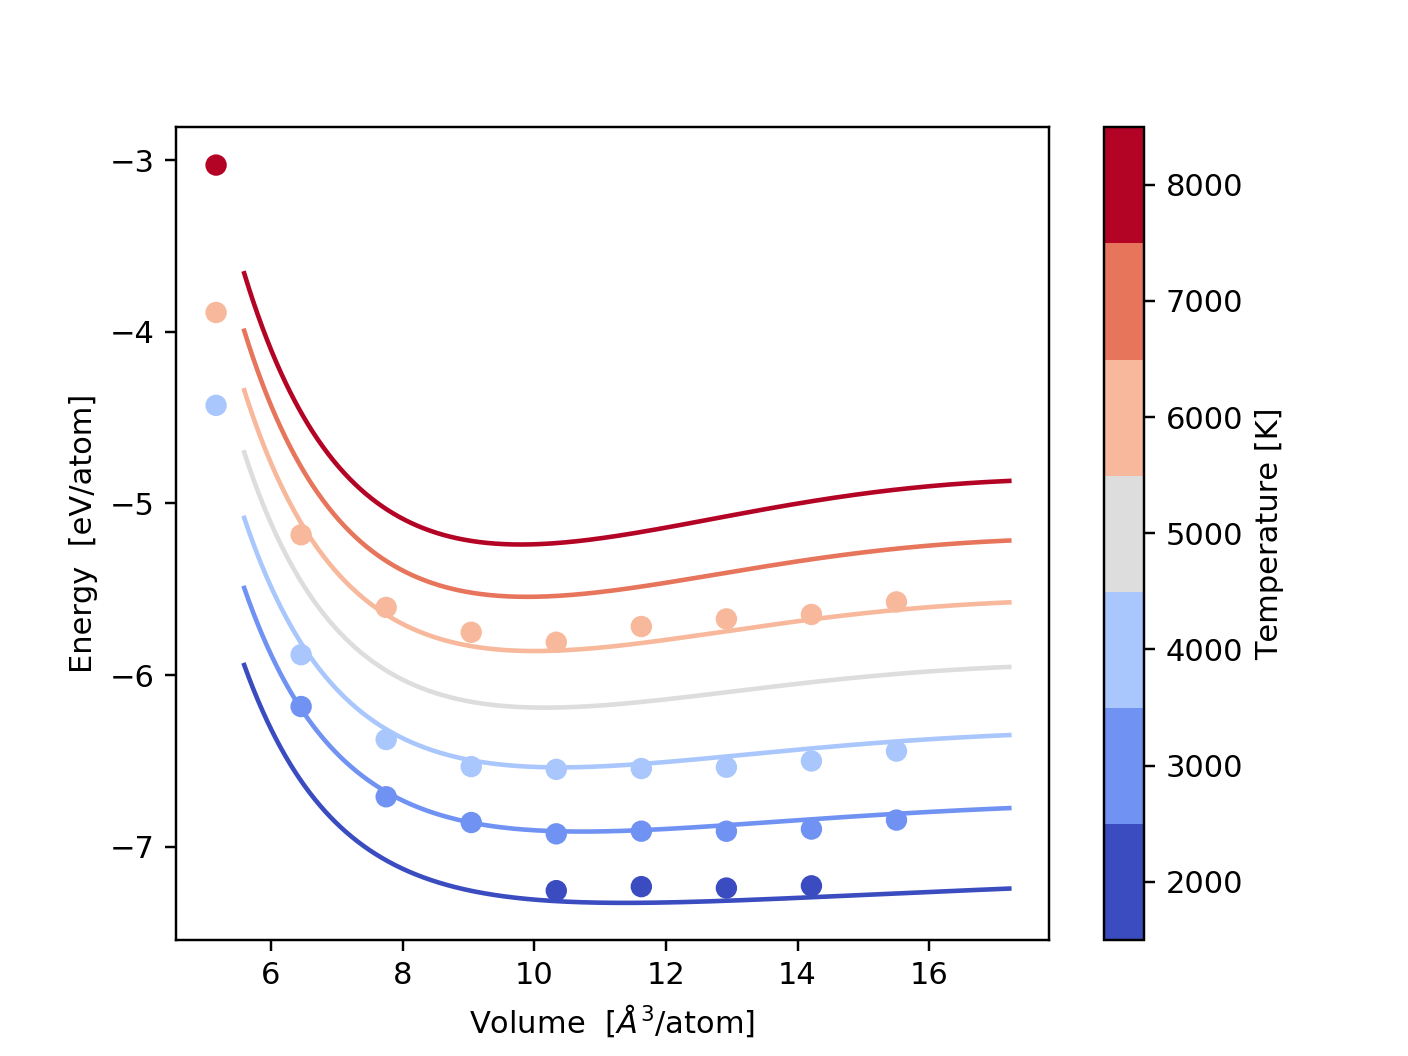

In [16]:
plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [17]:
def material_properties(Pref, Tref, eos_mod, Vref=None):
    if Vref is None:
        Vref = eos_mod.volume(Pref, Tref, Vinit=12.8)[0]
        
    KT = eos_mod.bulk_mod(Vref,Tref)[0]
    CV = eos_mod.heat_capacity(Vref,Tref)
    alpha =  eos_mod.thermal_exp(Vref,Tref)[0]
    gamma =  eos_mod.gamma(Vref,Tref)[0]
    KS = KT*(1+alpha*gamma*Tref)
    props = OrderedDict()
    props['P'] = Pref
    props['T'] = Tref
    props['V'] = Vref
    props['KT'] = KT
    props['KS'] =  KS
    props['Cv'] = CV/CONSTS['kboltz']
    props['therm_exp'] = alpha
    props['gamma'] = gamma
    return props

model_props = material_properties(0,1773, eos_mod)
display(model_props)

OrderedDict([('P', 0),
             ('T', 1773),
             ('V', 12.895188258848826),
             ('KT', 17.216929131356196),
             ('KS', 17.473761668199003),
             ('Cv', array([ 5.62024984])),
             ('therm_exp', 5.4227616765628208e-05),
             ('gamma', 0.15515475715879684)])

In [18]:
display(analysis['props_Lange'])
display(analysis['props_Ghiorso'])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

{'KS': 20.850204971850488,
 'P': 0,
 'T': 1673,
 'V': 12.860873922038328,
 'alpha': 0.0001005551969012266,
 'betaS': 0.047961159199637761,
 'c': 2835.855,
 'rho': 2592.6404131697873}